In [ ]:
import random
import numpy as np
import torch

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark     = False

import pandas as pd
import umap
# （以下、もともとのコードが続く…）


In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import umap
import matplotlib.pyplot as plt
import openpyxl

# 1. データ読み込み
xls = pd.ExcelFile("定額制動画配信.xlsx")
df = pd.read_excel(xls, sheet_name="data")
format_df = pd.read_excel(xls, sheet_name="Format")

# 2. サービスコード→サービス名マッピング（SQ6_1ベース）
sq6_1 = format_df[format_df["Question"].astype(str).str.startswith("SQ6_1[")][["Question","Title"]].dropna()
code_title = {
    int(q.split("[")[1].split("]")[0]): title
    for q, title in zip(sq6_1["Question"], sq6_1["Title"])
}



In [ ]:
# 3. 特徴量集計関数
def make_feature_df(df):
    features = []
    for code, svc in code_title.items():
        sub = df[df["SQ6_2"] == code]  # SQ6_2 = 「最もよく使っているサービス」
        if sub.empty:
            continue
        feat = {"Service": svc,
                # ① UX体験品質
                "UX_mean": sub[[f"Q2_{i}" for i in range(1,9)]].mean(axis=1).mean(),
                "UI_design": sub["Q2_3"].mean(),
                "Player_usability": sub["Q2_6"].mean(),
                # ② コンテンツ量・新作性
                "Catalogue_volume": sub["Q2_9"].mean(),
                "Genre_coverage_within_category": sub["Q2_10"].mean(),
                "New_release_speed": sub["Q2_11"].mean(),
                "Genre_coverage_among_category": sub[[f"SQ9_1[{i}]" for i in range(1,16)]].sum(axis=1).mean(),
                # ③ 価格バリュー
                "Cost_perf": sub["Q2_14"].mean(),
                # ④ ロイヤルティ
                "Overall_satisfaction": sub["Q1"].mean(),
                "NPS_intention": sub["Q4"].mean(),
                "Continue_intention": sub["Q8"].mean()
               }
        # ⑤ ジャンル強み
        for i in range(1, 16):
            feat[f"Genre_{i}_top_share"] = (sub["SQ9_3"] == i).mean()
        # ⑥ オリジナルコンテンツ力
        feat["Original_viewer_share"] = (sub["Q12M[3]"] == 3).mean()
        feat["Original_quality"] = sub[[f"Q13_{i}" for i in range(1,4)]].mean(axis=1).mean()
        # ⑦ 利用歴／アカウント形態
        tenure_map = {1:1,2:4,3:8,4:18,5:30,6:42}
        feat["Usage_tenure_months"] = sub["SQ8"].map(tenure_map).mean()
        feat["Personal_pay_ratio"] = sub["SQ7"].isin([1,2]).mean()
        # ⑧ 追加サービス／機能
        feat["Extra_service_use"] = sub["SQ10"].isin([1,2]).mean()
        # ⑨ イメージ・信頼
        feat["Corporate_trust"] = sub[["Q2_15","Q2_16"]].mean(axis=1).mean()
        # ⑩ SDGsプレミアム
        feat["SDGs_influence"] = sub["Q22"].mean()
        features.append(feat)
    return pd.DataFrame(features).set_index("Service")



In [29]:
# 4. 特徴量行列作成
feat_df = make_feature_df(df)

#欠損値を平均補完（Original_qualityのみ）
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="mean")
feat_df["Original_quality"] = imputer.fit_transform(feat_df[["Original_quality"]])

# 5. スケーリング＆PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(feat_df)
pca = PCA(n_components=2)
coords_pca = pca.fit_transform(X_scaled)
df_pca = pd.DataFrame(coords_pca, index=feat_df.index, columns=["PC1","PC2"])



In [30]:
#feat_dfの欠損値を確認(欠損しているカラムのみ表示)
# missing_cols = feat_df.columns[feat_df.isnull().any()]
# print("欠損値を含むカラム一覧:")
# for col in missing_cols:
#     print(f"{col}（欠損数: {feat_df[col].isnull().sum()}）")


findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Fo

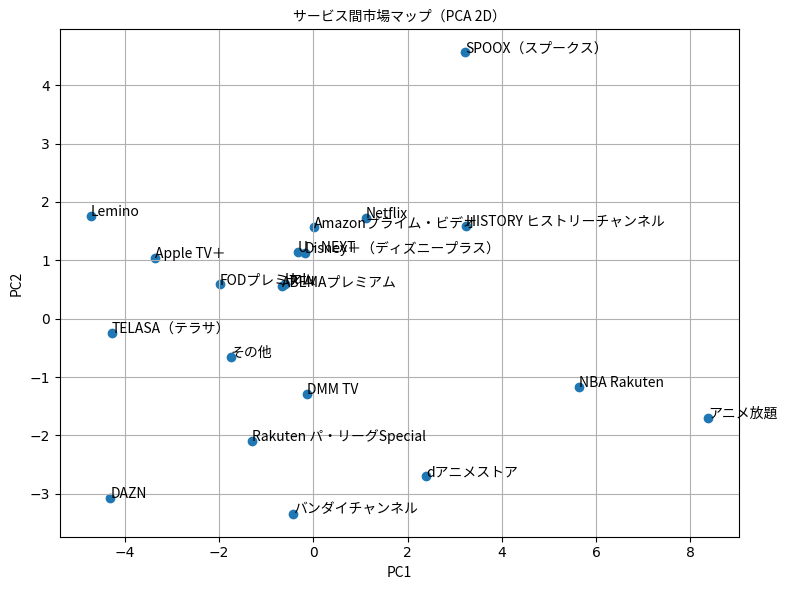

/home/fuukanoo/workspace/jisyu-zemi/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/fuukanoo/workspace/jisyu-zemi/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findf

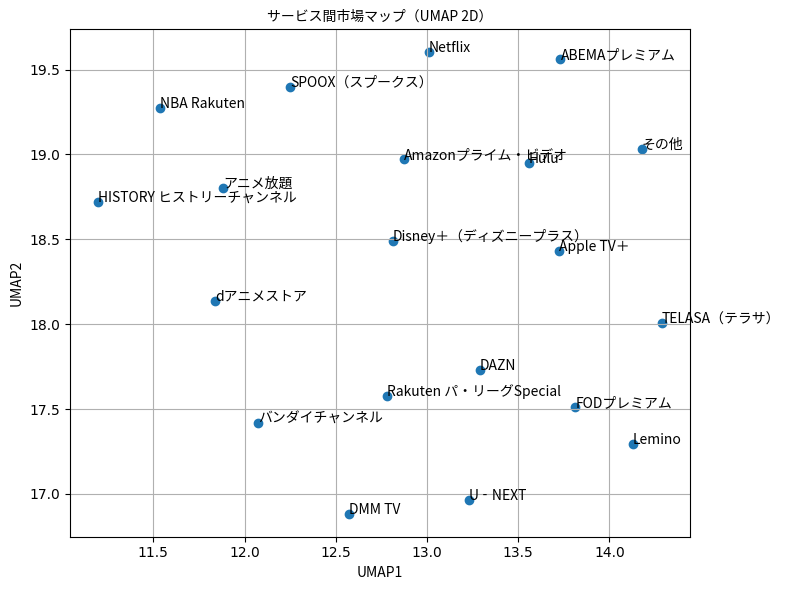

In [31]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# # フォント設定（Noto Sans CJK JPを指定）
# plt.rcParams['font.family'] = 'Noto Sans CJK JP'

# Noto Sans CJK JP のフォントパスを明示的に指定
font_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams["font.family"] = font_prop.get_name()

#可視化
plt.figure(figsize=(8,6))
plt.scatter(df_pca["PC1"], df_pca["PC2"])
for svc, (x,y) in df_pca.iterrows():
    plt.text(x, y, svc, fontproperties=font_prop)  # 👈 ここ重要！
plt.title("サービス間市場マップ（PCA 2D）", fontproperties=font_prop)
plt.xlabel("PC1", fontproperties=font_prop)
plt.ylabel("PC2", fontproperties=font_prop)
plt.grid(True)
plt.tight_layout()
plt.show()

# UMAPも同様に
# 7. UMAP （任意）
reducer = umap.UMAP(n_components=2, random_state=42)
coords_umap = reducer.fit_transform(X_scaled)
df_umap = pd.DataFrame(coords_umap, index=feat_df.index, columns=["UMAP1","UMAP2"])

plt.figure(figsize=(8,6))
plt.scatter(df_umap["UMAP1"], df_umap["UMAP2"])
for svc, (x,y) in df_umap.iterrows():
    plt.text(x, y, svc, fontproperties=font_prop)
plt.title("サービス間市場マップ（UMAP 2D）", fontproperties=font_prop)
plt.xlabel("UMAP1", fontproperties=font_prop)
plt.ylabel("UMAP2", fontproperties=font_prop)
plt.grid(True)
plt.tight_layout()
plt.show()



findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Fo

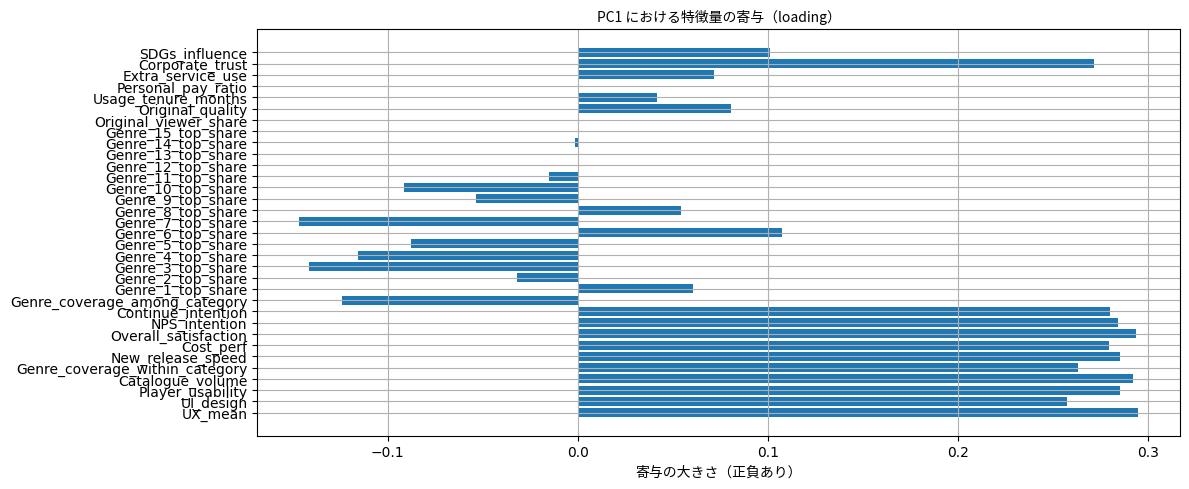

findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Fo

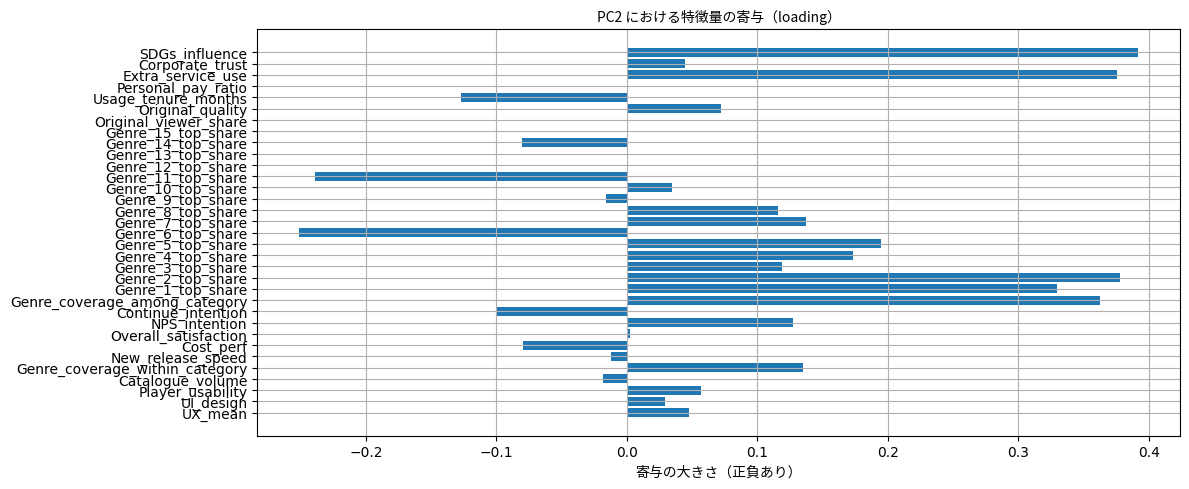

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# 特徴量名（feat_dfのカラム）
feature_names = feat_df.columns.tolist()

# PCAの成分（ロード）を取得（成分×特徴量）
loadings = pca.components_  # shape = (2, n_features)

# 可視化：PC1
plt.figure(figsize=(12, 5))
plt.barh(feature_names, loadings[0])
plt.title("PC1 における特徴量の寄与（loading）", fontproperties=font_prop)
plt.xlabel("寄与の大きさ（正負あり）", fontproperties=font_prop)
plt.grid(True)
plt.tight_layout()
plt.show()

# 可視化：PC2
plt.figure(figsize=(12, 5))
plt.barh(feature_names, loadings[1])
plt.title("PC2 における特徴量の寄与（loading）", fontproperties=font_prop)
plt.xlabel("寄与の大きさ（正負あり）", fontproperties=font_prop)
plt.grid(True)
plt.tight_layout()
plt.show()
